Seed set to 2021


IS CUDA AVAILABLE
True
Ignored unknown arguments: ['--f=c:\\Users\\eddie\\AppData\\Roaming\\jupyter\\runtime\\kernel-v2-2760rbDbbJ2PN5Jz.json']
ARGS teest
notebook
fulldire C:\Users\eddie\OneDrive\Documents\GitHub\NeuroPattern\lag-llama\model-size-scaling-logs\2021
Using lightning_version version_1 with epoch 96 restoring from checkpoint at path C:\Users\eddie\OneDrive\Documents\GitHub\NeuroPattern\lag-llama\model-size-scaling-logs\2021\experiments/lightning_logs/version_1/checkpoints\epoch=96-step=9700.ckpt
num_parameters :  3434755
Testing only
Use checkpoint: C:\Users\eddie\OneDrive\Documents\GitHub\NeuroPattern\lag-llama\model-size-scaling-logs\2021\experiments/lightning_logs/version_1/checkpoints\epoch=96-step=9700.ckpt
Predict on covid_weekly
window_size 13590
target: [1.5000e+01 4.2000e+01 2.2400e+02 1.3370e+03 5.7530e+03 1.3024e+04
 1.5803e+04 1.5132e+04 1.3785e+04 1.3053e+04 1.0239e+04 8.2970e+03
 7.5690e+03 6.1620e+03 5.5110e+03 4.4350e+03 6.1300e+03 4.3470e+03
 5.3750e+03 6.

AssertionError: 

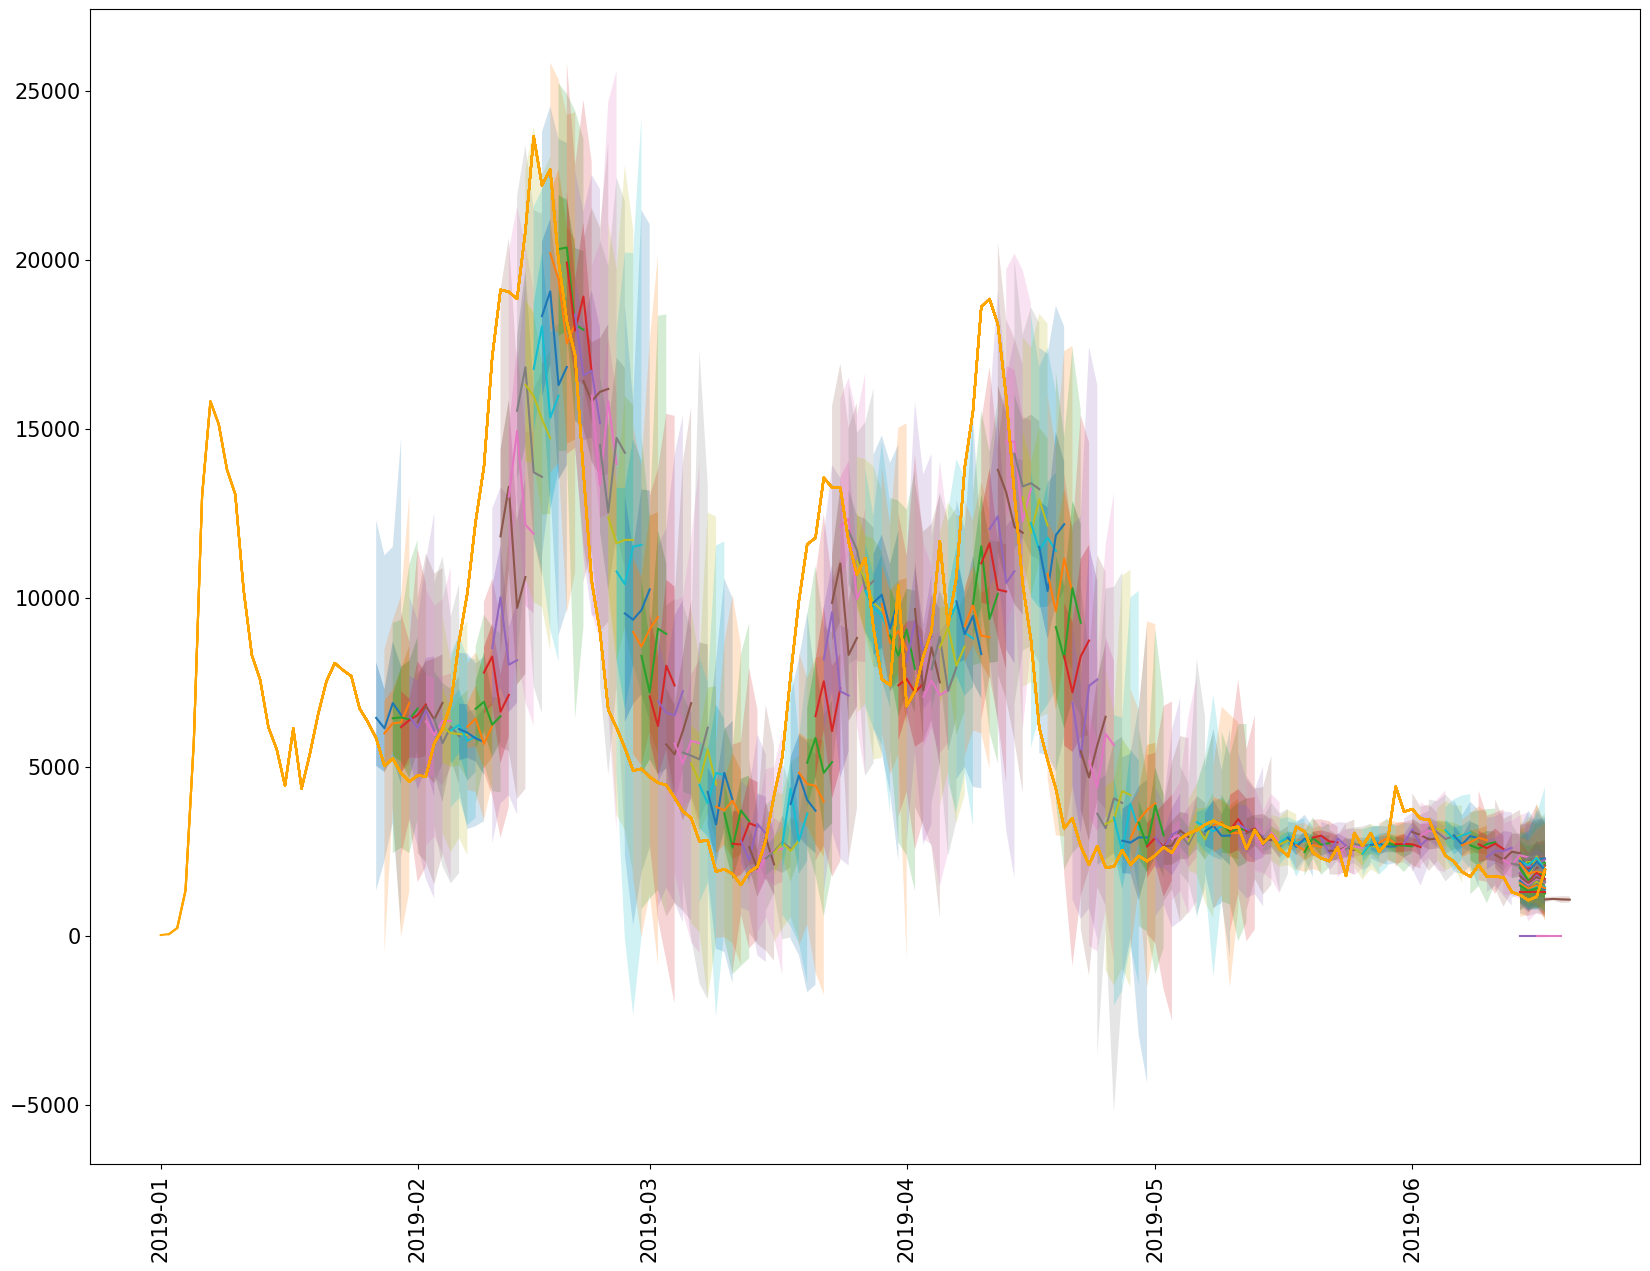

In [102]:
import argparse
from pathlib import Path
import pathlib
from glob import glob
from hashlib import sha1
import json
import os
import random
from itertools import islice
import numpy as np
import torch
import pytorch_lightning as L
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# Use this import style for PyTorch Lightning
from pytorch_lightning import Trainer
import pandas as pd
import numpy as np
import sys
from itertools import islice
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.evaluation._base import aggregate_valid
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.transform import ValidationSplitSampler
import matplotlib.ticker as ticker

from estimator import LagLlamaEstimator
import matplotlib.pyplot as plt


dataset_path = Path("../datasets_small")
test_dataset_path = Path("../test_data")


TRAIN_DATASET_NAMES = [
   #### "airpassengers",
    "australian_electricity_demand",##
    "car_parts_without_missing", ##
    "cif_2016", ##
   ## "covid_deaths",##
#####"electricity",
    "electricity_weekly",##
  ####  "exchange_rate",
    "fred_md",##
    "hospital",##
    "kaggle_web_traffic_weekly", # daily ##
    "kdd_cup_2018_without_missing",##
    "london_smart_meters_without_missing",##
    "nn5_daily_with_missing",##
    "nn5_weekly",##
    "pedestrian_counts",##
    "rideshare_without_missing",##
    "saugeenday",
   ### "solar-energy",
    "solar_10_minutes",##
    "solar_weekly",##
#####"taxi_30min",
    "temperature_rain_without_missing",##
    "tourism_monthly", ##
   #### "uber_tlc_daily",
  #####  "uber_tlc_hourly",
    "vehicle_trips_without_missing",##
    "weather",
   ### "wiki-rolling_nips",
    "m4_daily",##
    "m4_hourly",##
    "m4_monthly",##
    "m4_quarterly",
    "m4_yearly",##
    "wind_farms_without_missing",##
]

class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)

    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

def create_sliding_window_dataset(name, window_size, is_train=True):
    # Splits each time series into non-overlapping sliding windows
    global_id = 0

    freq = get_dataset(name, path=dataset_path).metadata.freq
    data = ListDataset([], freq=freq)
    dataset = get_dataset(name, path=dataset_path).train if is_train else get_dataset(name, path=dataset_path).test

    for x in dataset:
        windows = []
        for i in range(0, len(x['target']), window_size):
            windows.append({
                'target': x['target'][i:i+window_size],
                'start': x['start'] + i,
                'item_id': str(global_id),
                'feat_static_cat': np.array([0]),
            })
            global_id += 1
        data += ListDataset(windows, freq=freq)
    return data

def create_test_dataset(name, window_size, pred_length, fr):
    # Similar to `create_sliding_window_dataset` but for test dataset
    prediction_length = pred_length
    freq = fr
    global_id = 0
    data = ListDataset([], freq=freq)

    df = pd.read_csv('../test_data/' + name + '.csv')  
    # Convert the DataFrame into a numpy array
    custom_dataset = df.values
    custom_dataset = custom_dataset.reshape(1, 168) 

    start = pd.Period("01-01-2019", freq=fr)  # can be different for each time series
    #train_ds = ListDataset(
    #[{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    #freq=freq,
    #)
    # test dataset: use the whole dataset, add "target" and "start" fields
    test_ds = ListDataset(
        [{"target": x, "start": start} for x in custom_dataset], freq=freq
    )
    window_size = 30
    j = 0
    for x in test_ds:
        windows = []
        for i in range(0, len(x['target']), window_size):
            j = 0
            while j < window_size:
                windows.append({
                    'target': x['target'][i+j:i+window_size+j],
                    'start': x['start'] + i+j,
                    'item_id': str(global_id),
                    'feat_static_cat': np.array([0]),
                })
                j += 1
            
            global_id += 1
        data += ListDataset(windows, freq=freq)
        for window in windows:
                print("target:", window['target'])
                print("start:", window['start'])

    return data



    #data = []
    #for x in test_ds:
    #    offset = len(x['target']) - window_size - prediction_length
    #    if offset > 0:
    #        target = x['target'][-(window_size + prediction_length):]
    #        data.append({
    #            'target': target,
    #            'start': x['start'] + offset,
    #        })
    #    else:
    #        data.append(x)
    #        
    #print("data", data)
    #print(ListDataset(data, freq=freq))
    #return  ListDataset(data, freq=freq), prediction_length

def train(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    L.seed_everything(args.seed)

    #experiment_name = f'data-scaling-context-{args.context_length}-layer-{args.n_layer}-n_embd-{args.n_embd}-n_head-{args.n_head}-aug-{args.aug_prob}-{args.aug_rate}'
    fulldir = os.path.join(pathlib.Path().parent.resolve(), "model-size-scaling-logs", str(args.seed)) # Always creates the experiment directory inside "lag-llama"
    os.makedirs(fulldir, exist_ok=True)
    fulldir_experiments = os.path.join(fulldir, "experiments")
    os.makedirs(fulldir_experiments, exist_ok=True)
    print("fulldire", fulldir)
    
    
    # Code to retrieve the version with the highest #epoch stored and restore it incl directory and its checkpoint
    lightning_version_to_use, ckpt_path = None, None
    max_epoch = -1
    if "lightning_logs" in os.listdir(fulldir_experiments):
        for lightning_version in os.listdir(fulldir_experiments+"/lightning_logs/"):
            ckpts = glob(fulldir_experiments+"/lightning_logs/" + lightning_version + "/checkpoints/*.ckpt")
            if len(ckpts): 
                epoch = int(ckpts[0][ckpts[0].find("=")+1:ckpts[0].find("-step")])
                if epoch > max_epoch:
                    lightning_version_to_use = lightning_version
                    max_epoch = epoch
                    ckpt_path = ckpts[0]
        if lightning_version_to_use: print("Using lightning_version", lightning_version_to_use, "with epoch", max_epoch, "restoring from checkpoint at path", ckpt_path)
    else: print ("no lightning logs found. Training from scratch.")
    
    logger = CSVLogger(
        save_dir=fulldir_experiments,
        flush_logs_every_n_steps=1,
        version=lightning_version_to_use
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=int(args.early_stopping_patience), verbose=True, mode="min")
    model_checkpointing = ModelCheckpoint(save_top_k=1)
    callbacks = [early_stop_callback, model_checkpointing]

    estimators = LagLlamaEstimator(
        prediction_length=10,
        context_length=args.context_length,
        batch_size=args.batch_size,
        n_layer=args.n_layer,
        n_head=args.n_head,
        n_embd=args.n_embd,
        scaling="std",
        aug_prob=args.aug_prob,
        aug_rate=args.aug_rate,
        num_batches_per_epoch=args.num_batches_per_epoch,
        ckpt_path=ckpt_path,
        trainer_kwargs=dict(
            max_epochs=args.max_epochs,
            accelerator="gpu",
            devices=[args.gpu],
            limit_val_batches=args.limit_val_batches,
            logger=logger,
            callbacks=callbacks,
            default_root_dir=fulldir_experiments
        ),
    )
    
    num_parameters = sum(p.numel() for p in estimators.create_lightning_module().parameters())
    print("num_parameters : ", num_parameters)

    window_size = estimators.context_length + max(estimators.lags_seq) + estimators.prediction_length
    # Here we make a window slightly bigger so that instance sampler can sample from each window
    # An alternative is to have exact size and use different instance sampler (e.g. ValidationSplitSampler)
    window_size = 10 * window_size

    # We change ValidationSplitSampler to add min_past
    estimators.validation_sampler = ValidationSplitSampler(
        min_past=estimators.context_length + max(estimators.lags_seq),
        min_future=estimators.prediction_length,
    )

    if args.test:
        print('Testing only')
        
    else:
        # Create training data
        train_data, val_data = [], []
        for name in TRAIN_DATASET_NAMES:
            new_data = create_sliding_window_dataset(name, window_size)
            train_data.append(new_data)

            new_data = create_sliding_window_dataset(name, window_size, is_train=False)
            val_data.append(new_data)
        # Here weights are proportional to the number of time series (=sliding windows)
        weights = [len(x) for x in train_data]
        # Here weights are proportinal to the number of individual points in all time series
        # weights = [sum([len(x["target"]) for x in d]) for d in train_data]

        train_data = CombinedDataset(train_data, weights=weights)
        val_data = CombinedDataset(val_data, weights=weights)

        # Train
        # TODO: Depending on the stopping criterion, saved checkpoint will be based on validation
        # and the test set for these datasets will be the same (doesn't impact zero-shot experiment)
        train_output = estimators.train_model(
            training_data=train_data,
            validation_data=val_data,
            ckpt_path=ckpt_path
        )

    #estimator.ckpt_path = train_output.trainer.checkpoint_callback.best_model_path
    print(f'Use checkpoint: {estimators.ckpt_path}')
    
    ## TEST DATASET #################################################################################

    freq = "1D"
    prediction_length = 4
    ## TEST DATASET #################################################################################

    # for name in ['m4_weekly', 'traffic'] + TRAIN_DATASET_NAMES:
    #for name in ['m4_weekly', 'traffic'] + TRAIN_DATASET_NAMES[0:5]:
    for name in ['covid_weekly']:
        print(f'Predict on {name}')
        print("window_size", window_size)
        
        test_data = create_test_dataset(name, window_size, prediction_length, freq)
        #print(f'{name} prediction length: {prediction_length}')       
        
        # Adapt evaluator to new dataset
        estimators.prediction_length = prediction_length
        #estimators.batch_size = max(30 // estimators.prediction_length, 1) # Some heuristic for GPU memory (TODO: change)
        predictor = estimators.create_predictor(
            estimators.create_transformation(),
            estimators.create_lightning_module(),
        )
        ## Make evaluations
        
        plt.figure(figsize=(20, 15))
        plt.rcParams.update({"font.size": 15})

        # Iterate over each window in the test data
        for idx, window in enumerate(test_data):
            # Generate predictions for the window
            forecast_it, ts_it = make_evaluation_predictions(
                dataset=[window],  # Pass the window as a one-item list
                predictor=predictor,
            )
            forecasts = list(forecast_it)
            tss = list(ts_it)

            # Plot the actual and predicted values
            #ax = plt.subplot(3, 3, idx + 1)
            plt.plot(tss[0].to_timestamp(), label="truth", color="orange")
            #plt.plot(forecasts[0].to_timestamp(), label="target")
            forecasts[0].plot()
            
            
            print("HEEEEEEEEEEER", forecasts[0].start_date)
            plt.xticks(rotation=90)

        plt.gcf().tight_layout()
        plt.legend()
        plt.show()
        #forecast_it, ts_it = make_evaluation_predictions(
        #    dataset=test_data,
        #    predictor=predictor,
        #)
#
        #forecasts = list(forecast_it)
        #tss = list(ts_it)
#
        #plt.figure(figsize=(20, 15))
        #plt.rcParams.update({"font.size": 15})
#
        #for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 1):
        #    ax = plt.subplot(3, 3, idx + 1)
        #    plt.plot(ts.to_timestamp(), label="target")  # Modify this line
        #    forecast.plot()
        #    plt.xticks(rotation=60)
#
        #plt.gcf().tight_layout()
        #plt.legend()
        #plt.show()

        #forecast_it, ts_it = make_evaluation_predictions(
        #    dataset=test_data,
        #    predictor=predictor,
        #)
        ##
        #forecasts = list(forecast_it)
        #tss = list(ts_it)
        #
#
        #
        #plt.figure(figsize=(20, 15))
        #plt.rcParams.update({"font.size": 15})
#
        #for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 1):
        #    ax = plt.subplot(3, 3, idx + 1)
        #    plt.plot(ts.to_timestamp(), label="target")  # Modify this line
        #    forecast.plot()
        #    plt.xticks(rotation=60)
#
        #plt.gcf().tight_layout()
        #plt.legend()
        #plt.show()

        #evaluator = Evaluator(num_workers=1, aggregation_strategy=aggregate_valid)
        #agg_metrics, _ = evaluator(
        #    iter(tss), iter(forecasts), num_series=len(test_data)
        #)
        #
        #agg_metrics["trainable_parameters"] = num_parameters
        #agg_metrics["n_layer"] = args.n_layer
        #agg_metrics["n_embd"] = args.n_embd
        #agg_metrics["n_head"] = args.n_head
#
        #print("logger.log_dir : ", logger.log_dir)
        #print("os.path.exists(logger.log_dir) : ", os.path.exists(logger.log_dir))
#
        #if not os.path.exists(logger.log_dir):
        #    os.makedirs(logger.log_dir)
        #with open(f'{logger.log_dir}/{name}.json', 'w') as f:
        #    json.dump(agg_metrics, f)


import torch
print("IS CUDA AVAILABLE")
print(torch.cuda.is_available())
parser = argparse.ArgumentParser(allow_abbrev=False)

#estimator args
parser.add_argument("--seed", type=int,  default=2021)
parser.add_argument("--context_length", type=int, default=256)
parser.add_argument("--n_layer", type=int, default=4)
parser.add_argument("--n_embd", type=int, default=256)
parser.add_argument("--n_head", type=int, default=4)
parser.add_argument("--aug_prob", type=float, default=0.5)
parser.add_argument("--aug_rate", type=float, default=0.1)
parser.add_argument("--batch_size", type=int, default=100)
parser.add_argument("--num_batches_per_epoch", type=int, default=100)
# estimator trainer kwarg args
parser.add_argument("--limit_val_batches", type=int, default=10)
parser.add_argument("--max_epochs", type=int, default=100)
parser.add_argument("--gpu", type=int, default=0)
# Other args

parser.add_argument('--test', default=True)


#parser.add_argument('--test', action='store_true')
parser.add_argument('--early_stopping_patience', default=50)
# Model

parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')

args, unknown_args = parser.parse_known_args()

# Ignore unknown arguments
if unknown_args:
    print(f"Ignored unknown arguments: {unknown_args}")
    
    
# Use a placeholder filename for notebooks
file_path = "notebook" if "__file__" not in globals() else pathlib.Path(__file__).parent.resolve()
print("ARGS teest")
print(file_path)

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
train(args)